In [1]:
from plyfile import PlyData, PlyElement
import numpy as np
import pandas as pd
import pyvista as pv
import sys
import os.path as osp
from matplotlib import pyplot as plt
sys.path.append("./segmentation/cutpursuit/pcd-prox-split/grid-graph/python")
from grid_graph import edge_list_to_forward_star # type: ignore
from segmentation.cutpursuit.python.wrappers.cp_d0_dist import cp_d0_dist



# pcd_fp = "./data/flatLabels/flatLabels_viadukt.ply"
# pcd_fp = "./data/flatLabels/flatLabels_twingen.ply"
pcd_fp = "./data/flatLabels/flatLabels_westbahnhof.ply"
# pcd_fp = "./data/flatLabels/flatLabels_niebelungen.ply"

pcd = pd.DataFrame(PlyData.read(pcd_fp).elements[0].data)





In [2]:
import yaml
with open(osp.join(osp.split(pcd_fp)[0],osp.basename(pcd_fp).replace('.ply','.yaml')),'r') as f:
    label_schema = yaml.safe_load(f)

label_map = {
    'flatLabels_westbahnhof.ply' : 
        np.array([
            [0, 0], #'cable',
            [1, 0], #'concrete_beam',
            [2, 0], #'concrete_cover',
            [3, 1], #'concrete_cover_damaged',
            [4, 0], #'efflorecence',
            [5, 0], #'graffiti',
            [6, 0], #'lamps',
            [7, 0], #'reinforcment',
            [8, 0], #'spalling'
        ]),
    'flatLabels_twingen.ply':
        np.array([
            [0, 0], #'paving',
            [1, 0], #'pier_cap',
            [2, 0], #'pipe',
            [3, 0], #'pipe_fasteners',
            [4, 0], #'railing',
            [5, 0], #'unspecified',
            [6, 0], #'vegetation',
            [7, 0], #'scan_artefact',
            [8, 0], #'road_barrier',
            [9, 0], #'kerbstone',
            [10, 0], #'deck',
            [11, 1], #'roadway',
            [12, 0], #'road_marking',
            [13, 0], #'column',
            [14, 0], #'natural_ground',
        ]),
    'flatLabels_viadukt.ply':
        np.array([
            [0, 0], # concrete
            [1, 1], # brick
        ]),
    'flatLabels_niebelungen.ply':
        np.array([
            [0, 0], # 'addon',
            [1, 0], # 'attatchment',
            [2, 0], # 'beam',
            [3, 1], # 'column',
            [4, 0], # 'deck',
            [5, 0], # 'fundament',
            [6, 0], # 'pipe',
            [7, 0], # 'railing',
            [8, 0], # 'roadway',
            [9, 0], # 'road_barrier',
            [10, 0], # 'road_marking',
            [11, 0], # 'scan_artefact',
        ]),

}
 
 

In [3]:
pcd.columns
field_map = {
    'flatLabels_westbahnhof.ply':{
        'x' : 'x',
        'y' : 'y',
        'z' : 'z',
        'red' : 'red',
        'green' : 'green',
        'blue' : 'blue',
        'riegl_reflectance' : 'riegl_reflectance',
        'riegl_deviation' : 'riegl_deviation',
        'labels' : 'labels',
    },
    'flatLabels_twingen.ply':{
        'x':'x',
        'y':'y',
        'z':'z',
        'red':'red',
        'green':'green',
        'blue':'blue',
        'intensity':'intensity',
        'labels':'labels',
    },
    'flatLabels_viadukt.ply':{
        'x' : 'x',
        'y' : 'y',
        'z' : 'z',
        'red' : 'red',
        'green' : 'green',
        'blue' : 'blue',
        'scalar_material' : 'labels',
    },
    'flatLabels_niebelungen.ply':{
        'x' : 'x',
        'y' : 'y',
        'z' : 'z',
        'red' : 'red',
        'green' : 'green',
        'blue' : 'blue',
        'Intensity' : 'intensity',
        'labels' : 'labels',
    }
}

In [4]:
# load and remap fields

pos = pcd[['x','y','z']].to_numpy().astype(np.float32)
rgb = pcd[['red','green','blue']].to_numpy().astype(np.float32)
label = pcd['labels'].to_numpy().astype(int)

fn = osp.basename(pcd_fp)
# remap labels
label_bin = label_map[fn][:,1][label]

# Camera

In [5]:
# reset camera_positions dict
camera_positions = dict()

In [6]:
# load camera positions dict
import pickle
with open('./data/flatLabels/camera_positions.pkl','rb') as f:
    camera_positions = pickle.load(f)

In [7]:
# # capture camera position in a dict
# import os.path as osp
# current_camera_position = plotter.camera_position
# camera_positions[osp.basename(pcd_fp)] = current_camera_position


In [8]:
# # save camera_pos_dict
# import pickle
# with open('./data/flatLabels/camera_positions.pkl','wb') as f:
#     pickle.dump(camera_positions, f)

In [9]:
# reset camera position
def reset_camera_standard(plotter:pv.Plotter):
    standard_view = camera_positions[osp.basename(pcd_fp)]
    plotter.camera_position = standard_view
    plotter.render()


In [12]:
# visualize loaded file

plotter = pv.Plotter(notebook=True)
pcd_poly = pv.PolyData(pos)
pcd_poly['RGB']=rgb
pcd_poly['label_bin']=label_bin
# plotter.add_mesh(pcd_poly,scalars='RGB',rgb=True)
plotter.add_mesh(pcd_poly,scalars='label_bin')
plotter.show(jupyter_backend='trame')
reset_camera_standard(plotter)

Widget(value='<iframe src="http://localhost:33103/index.html?ui=P_0x7be53a35be90_1&reconnect=auto" class="pyvi…

 JS Error => error: Uncaught TypeError: Cannot mix BigInt and other types, use explicit conversions
 JS Error => error: Uncaught TypeError: Cannot mix BigInt and other types, use explicit conversions
 JS Error => error: Uncaught TypeError: Cannot mix BigInt and other types, use explicit conversions


# Segmentation

In [13]:
from segmentation.interactive_gc import scatter_eig
from torch_geometric.nn import knn_graph
from typing import Optional, Tuple
from torch_scatter import scatter_add
import torch
@torch.no_grad()
def scatter_eigendecomposition(src:torch.Tensor, index: torch.Tensor, G:Optional[int]=None, eps:float=1e-6)->Tuple[torch.Tensor, torch.Tensor]:
    """Performs eigendecomposition on subsets of `src` defined by `index`

    Args:
        src (torch.Tensor): Source data [N,D]
        index (torch.Tensor): Index into output [N,]->[0..G]
        G (int): Sets the output size explicitly, defaults to max(index) +1

    Returns:
        Tuple[torch.Tensor,torch.Tensor]: sorted eigenvalues [G,D] and corresponding eigenvectors [G,D]
    """
    
    # _, counts = torch.unique(index, return_counts=True)
    if G is None:
        G = int(index.amax().item()) + 1
    
    N, D = src.shape
    counts = torch.bincount(index, minlength=G)
    
    # print(f'old G={int(index.max().item()) + 1}, WhyNotThisG = {counts.size(0)}')
    # if (int(index.max().item()) + 1 != counts.size(0)):
    #     raise Exception


    ones    = torch.ones_like(index, dtype=src.dtype)
    counts  = scatter_add(ones, index, dim=0, dim_size=G)  # [G]



    sum_src = scatter_add(src, index, dim=0, dim_size=G)        # [G,D]
    mu = sum_src / (counts[:,None]+eps)                         # [G,D]

    x = src [...,None]              # [N,D,1]
    xxT = x @ x.permute(0,2,1)      # [N,D,D]
    xxT_flat = xxT.reshape(N,D*D)   # [N,D^2]

    sum_xxT_flat = scatter_add(xxT_flat, index, dim=0, dim_size=G)      # [G,D^2]
    E_xxT = sum_xxT_flat / (counts[:,None]+eps)                         # [G,D,D]
    E_xxT = E_xxT.reshape(G, D, D)


    mu_muT = mu[...,None] @ mu[:,None,:]    # [G,D,1] @ [G,!,D] -> [G,D,D]
    cov = E_xxT - mu_muT                    # [G,D,D]
    
    # Ridge (Tikhonov)-regularization
    eye = torch.eye(D, device=src.device).unsqueeze(0)  # [1,D,D]
    cov = cov + eps * eye

    eigenvals, eigenvecs = torch.linalg.eigh(cov)

    return eigenvals, eigenvecs

In [14]:
# pointwise geometric features
from segmentation.interactive_gc import scatter_eig
from torch_geometric.nn import knn_graph, radius_graph
from torch_scatter import scatter_mean
import torch


pos_t = torch.as_tensor(pos)
# nb_i, ct_i = knn_graph(pos_t, k=16)
edge_idx = knn_graph(pos_t, k=50)
ct_i, nb_i = edge_idx

rel_pos_nb = pos_t[nb_i] - pos_t[ct_i]






evals, evecs = scatter_eigendecomposition(rel_pos_nb, ct_i, G = pos.shape[0])



eps = 1e-5
l1, l2, l3 = evals[:,0], evals[:,1], evals[:,2]
normals = evecs[:,:,0]
verticality = normals[:,2].abs()
linearity  = (l3 - l2) / (l3 + eps)
planarity  = (l2 - l1) / (l3 + eps)
scattering = l1 / (l3 + eps)
sum_evals = l1 + l2 + l3 + eps
omnivariance = (l1 * l2 * l3).pow(1/3)
anisotropy = (l3 - l1) / (l3 + eps)
p1 = l1 / sum_evals
p2 = l2 / sum_evals
p3 = l3 / sum_evals
eigenentropy = -(p1 * torch.log(p1 + eps) + p2 * torch.log(p2 + eps) + p3 * torch.log(p3 + eps))
change_curvature = l1 / sum_evals
sphericity = change_curvature 
# surface_variation = l1 / (l1 + l2 + l3 + eps)
# feature_flatness = l2 / (l3 + eps)

feat = scattering.numpy()
feat -= feat.min()
feat /= feat.max()
plotter2 = pv.Plotter(notebook=True)
pcd_poly['feat'] = feat
plotter2.add_mesh(pcd_poly,scalars='feat')
plotter2.show()



Widget(value='<iframe src="http://localhost:33103/index.html?ui=P_0x7be3df40ef00_2&reconnect=auto" class="pyvi…

In [15]:
def build_csr(edge_idx: torch.Tensor, num_nodes: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    sys.path.append("./segmentation/cutpursuit/pcd-prox-split/grid-graph/python")
    from grid_graph import edge_list_to_forward_star
    indptr, indices, reidx = edge_list_to_forward_star(
        num_nodes, edge_idx.T.contiguous().cpu().numpy()
    )
    return indptr.astype(np.uint32), indices.astype(np.uint32), reidx


In [16]:
import colorsys

def index_to_color(indices):
    """
    Map integer indices to vibrant RGB colors.

    Parameters
    ----------
    indices : int or array-like of ints
        Input index or indices. Can be a scalar or an iterable of ints.

    Returns
    -------
    colors : ndarray of shape (N, 3)
        RGB colors in the range [0, 1], where N is the number of indices.
    """
    # Ensure array of ints
    indices = np.atleast_1d(np.array(indices, dtype=int).flatten())
    
    # Use the golden ratio conjugate to spread hues evenly
    phi = 0.618033988749895
    hues = (indices * phi) % 1.0
    
    # Vibrancy settings
    s, v = 0.9, 0.95  # saturation and value
    
    # Convert each hue to RGB
    colors = np.array([colorsys.hsv_to_rgb(h, s, v) for h in hues], dtype=float)
    return colors

In [ ]:
# build partition


edge_idx = torch.cat([edge_idx, edge_idx.flip(0)], dim=1)
src, tgt, _ = build_csr(edge_idx, pos.shape[0])

cp_args_fine = dict(
    regularization = 0.8,
    spatial_weight = 100,
    cutoff = 15,
    cp_dif_tol =  1e-2,
    cp_it_max = 20,
    split_damp_ratio = 0.7
)
elevation = pos[:,2] - pos[:,2].min()
feats_point = np.concat([
    rgb,
    normals,
    verticality[:,None],
    linearity[:,None],
    planarity[:,None],
    scattering[:,None],
    # sphericity[:,None],
    elevation[:,None]
],axis=1)


feats_point -= feats_point.mean(axis=0)
feats_point /= np.std(feats_point,axis=0)


# fine cut-pursuit (get super_fine, graph_f)
Df = pos.shape[1] + feats_point.shape[1]
Xf = np.asfortranarray(np.concatenate([pos - pos.mean(0), feats_point], axis=1).T,
                        dtype=np.float64)
ew = np.ones_like(tgt, np.float64) * cp_args_fine.get('regularization', 0.1)
vw = np.ones(pos.shape[0], np.float64)
cw = np.ones(Df, np.float64)
cw[:pos.shape[1]] *= cp_args_fine.get('spatial_weight', 10.0)
sup_f, _, graph_f = cp_d0_dist(
    Df, Xf, src, tgt,
    edge_weights=ew, vert_weights=vw, coor_weights=cw,
    min_comp_weight=cp_args_fine.get('cutoff',5),
    cp_dif_tol=cp_args_fine.get('cp_dif_tol',1e-2),
    cp_it_max=cp_args_fine.get('cp_it_max',10),
    split_damp_ratio=cp_args_fine.get('split_damp_ratio',0.7),
    verbose=False, max_num_threads=0,
    balance_parallel_split=True,
    compute_List=False, compute_Graph=True, compute_Time=False
)

sup_colors = index_to_color(sup_f)

plotter3 = pv.Plotter(notebook=True)
pcd_poly = pv.PolyData(pos)
pcd_poly['RGB'] = sup_colors
plotter3.add_mesh(pcd_poly,scalars='RGB',rgb=True)
plotter3.show()

Widget(value='<iframe src="http://localhost:33103/index.html?ui=P_0x7be3dd987320_3&reconnect=auto" class="pyvi…

In [18]:
from torch_scatter import scatter_add

container = torch.zeros((sup_f.max()+1,2),dtype=torch.int64)
label_oh = torch.as_tensor(np.concatenate([(label_bin==0)[:,None], (label_bin==1)[:,None]],axis=1),dtype=torch.int64)

container = scatter_add(label_oh,torch.as_tensor(sup_f,dtype=torch.int64),dim=0,dim_size=sup_f.max()+1)

In [19]:
counts = container.float()
totals = counts.sum(dim=1, keepdim=True)
totals = torch.clamp(totals,min=1.0)
probs = counts / totals
eps=1e-8
entropy = -(probs * torch.log(probs+eps)).sum(1)
entropy_bits = entropy / np.log(2)
sup_labels = torch.argmax(counts,dim=1)



(array([498., 132.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

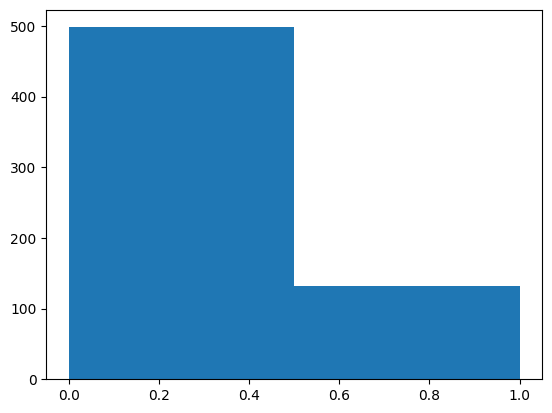

In [20]:
plt.hist(sup_labels,bins=2)

In [21]:
# calculate superpoint features
rgb_pt = torch.tensor(rgb)
intensity_pt = None
normals_pt = normals
verticality_pt = verticality[:,None]
linearity_pt = linearity[:,None]
planarity_pt = planarity[:,None]
scattering_pt = scattering[:,None]
sphericity_pt = sphericity[:,None]
elevation_pt = torch.as_tensor(elevation[:,None]).float()

# mean_pt_feat
rgb_sup = scatter_mean(rgb_pt, torch.as_tensor(sup_f,dtype=torch.int64),dim=0) if rgb_pt is not None else None
intensity_sup = scatter_mean(intensity_pt, torch.as_tensor(sup_f,dtype=torch.int64),dim=0) if intensity_pt is not None else None
normals_sup = scatter_mean(normals_pt, torch.as_tensor(sup_f,dtype=torch.int64),dim=0) if normals_pt is not None else None
verticality_sup = scatter_mean(verticality_pt, torch.as_tensor(sup_f,dtype=torch.int64),dim=0) if verticality_pt is not None else None
linearity_sup = scatter_mean(linearity_pt, torch.as_tensor(sup_f,dtype=torch.int64),dim=0) if linearity_pt is not None else None
planarity_sup = scatter_mean(planarity_pt, torch.as_tensor(sup_f,dtype=torch.int64),dim=0) if planarity_pt is not None else None
scattering_sup = scatter_mean(scattering_pt, torch.as_tensor(sup_f,dtype=torch.int64),dim=0) if scattering_pt is not None else None
sphericity_sup = scatter_mean(sphericity_pt, torch.as_tensor(sup_f,dtype=torch.int64),dim=0) if sphericity_pt is not None else None
elevation_sup = scatter_mean(elevation_pt, torch.as_tensor(sup_f,dtype=torch.int64),dim=0) if elevation_pt is not None else None

all_feats_sup = torch.concat([f for f in[rgb_sup,intensity_sup,normals_sup,verticality_sup,linearity_sup,planarity_sup,scattering_sup,sphericity_sup,elevation_sup] if f is not None],dim=1)

feat = scattering_sup
plotter4 = pv.Plotter(notebook=True)
pcd_poly_feat = pv.PolyData(pos)
pcd_poly_feat['sup_feat'] = feat[sup_f]
plotter4.add_mesh(pcd_poly_feat, scalars='sup_feat')
plotter4.show(jupyter_backend='trame')

Widget(value='<iframe src="http://localhost:33103/index.html?ui=P_0x7be3dd876720_4&reconnect=auto" class="pyvi…

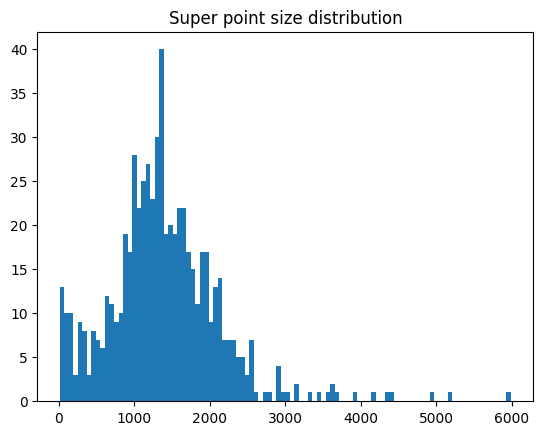

In [22]:
u,c = torch.unique(torch.as_tensor(sup_f,dtype=torch.int64), return_counts=True)
plt.hist(c, bins=100)
plt.title('Super point size distribution')
plt.show()

/tmp/ipykernel_1218322/1696189385.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


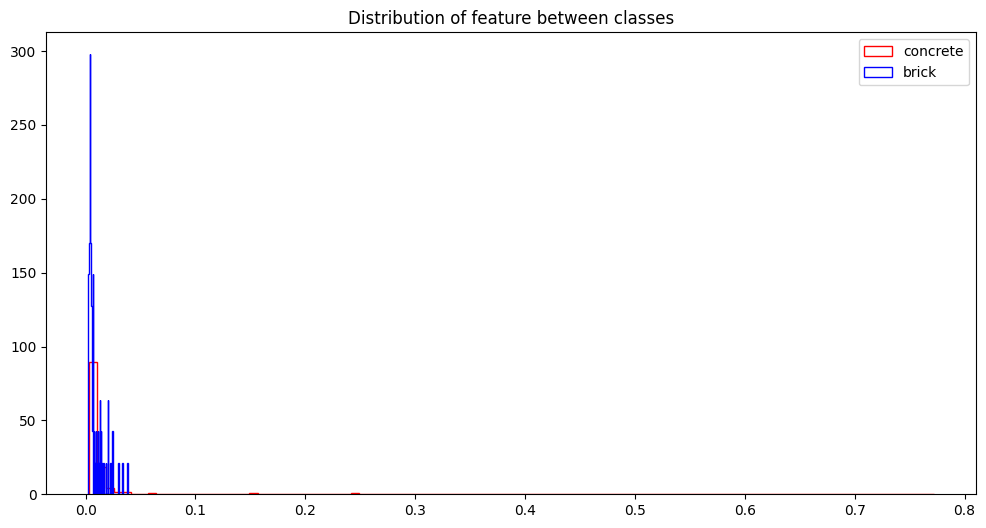

In [23]:
feat_0 = feat[sup_labels==0]
feat_1 = feat[sup_labels==1]

fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.hist(feat_0[:],bins=100, edgecolor='red',histtype='step',density=True,label='concrete')
ax.hist(feat_1[:],bins=100, edgecolor='blue',histtype='step',density=True, label='brick')
ax.legend()
ax.set_title('Distribution of feature between classes')
fig.show()


# MMG Model

In [24]:
from sklearn.mixture import GaussianMixture
import random
print(all_feats_sup.shape)

k = 500
n_components = 10

all_feats_sup_trans = all_feats_sup - all_feats_sup.mean(dim=0)
all_feats_sup_trans /= all_feats_sup_trans.std(dim=0)

model_fg = GaussianMixture(n_components=n_components, covariance_type='full')
model_bg = GaussianMixture(n_components=n_components, covariance_type='full')


mask_0 = torch.tensor([v.item() for v in random.choices(torch.nonzero(sup_labels==0),k=k)])
mask_1 = torch.tensor([v.item() for v in random.choices(torch.nonzero(sup_labels==1),k=k)])


model_fg.fit(all_feats_sup[mask_0].numpy())
model_bg.fit(all_feats_sup[mask_1].numpy())


score_fg = model_fg.predict(all_feats_sup_trans.numpy())
score_bg = model_bg.predict(all_feats_sup_trans.numpy())

plotter5 = pv.Plotter(notebook=True)
pcd_poly_scores = pv.PolyData(pos)
pcd_poly_scores['s'] = np.zeros((pos.shape[0],3),dtype=np.float32)
pcd_poly_scores['s'] = np.concat([c[:,None] for c in [(score_bg/score_bg.max())[sup_f],np.zeros(pos.shape[0],dtype=float),np.zeros(pos.shape[0],dtype=float)]],axis=1)

pcd_poly_scores['s'][torch.isin(torch.as_tensor(sup_f).long(),mask_0)] = [0,0,1]
pcd_poly_scores['s'][torch.isin(torch.as_tensor(sup_f).long(),mask_1)] = [0,1,0]

plotter5.add_mesh(pcd_poly_scores,scalars='s',rgb=True)
plotter5.show()








torch.Size([630, 12])


Widget(value='<iframe src="http://localhost:33103/index.html?ui=P_0x7be3a418e6f0_5&reconnect=auto" class="pyvi…

In [25]:
((score_bg > 0.5) == sup_labels).sum()/sup_labels.shape[0]

tensor(0.2095)

# MLP Model

In [26]:
import torch
from torch import nn

from typing import List

class MLP(nn.Module):
    def __init__(self,channels:List[int],dropout:List[float]|float|None = None):
        super().__init__()

        self.mlp = nn.Sequential(*[nn.Linear(channels[i], channels[i+1]) for i in range(len(channels) - 1)])
        if isinstance(dropout, float):
            self.dropout = nn.Dropout(dropout)
        elif isinstance(dropout, list):
            assert len(dropout) == len(channels)-1
            self.dropout = nn.ModuleList([nn.Dropout(p) for p in dropout])
        else:
            self.dropout = None
    def forward(self, x):
        for i, m in enumerate(self.mlp):
            x = m(x)
            if i < len(self.mlp) -1:
                x = nn.functional.relu(x)
            if self.dropout is not None:
                if isinstance(self.dropout, nn.ModuleList):
                    x = self.dropout[i](x)
                else:
                    x = self.dropout(x)
        x = torch.nn.functional.log_softmax(x,dim=1)
        return x
    def fit(self,
            x:torch.Tensor, 
            y:torch.Tensor,
            criterion = torch.nn.CrossEntropyLoss(),
            epochs:int=100,
            device='cuda',
            lr=0.01,
            weight_decay:float = 1e-4,
            optim:torch.optim.Optimizer|None=None,
            ):
        self.train()
        if optim is None:
            optim = torch.optim.Adam(
                self.parameters(),
                lr=lr,
                weight_decay=weight_decay
                )
        x = x.to(device=device)
        y = y.to(device=device)
        self.to(device=device)
        loss = torch.tensor(0)
        for epoch in range(1,epochs+1):
            optim.zero_grad()
            out = self(x)
            loss = criterion(out,y)
            loss.backward()
            optim.step()
        print(f"DEBUG fit MLP with loss={loss.detach().cpu().item():.3f}")
    def predict(self, x):
        self.eval()
        return self(x)



DEBUG fit MLP with loss=0.172


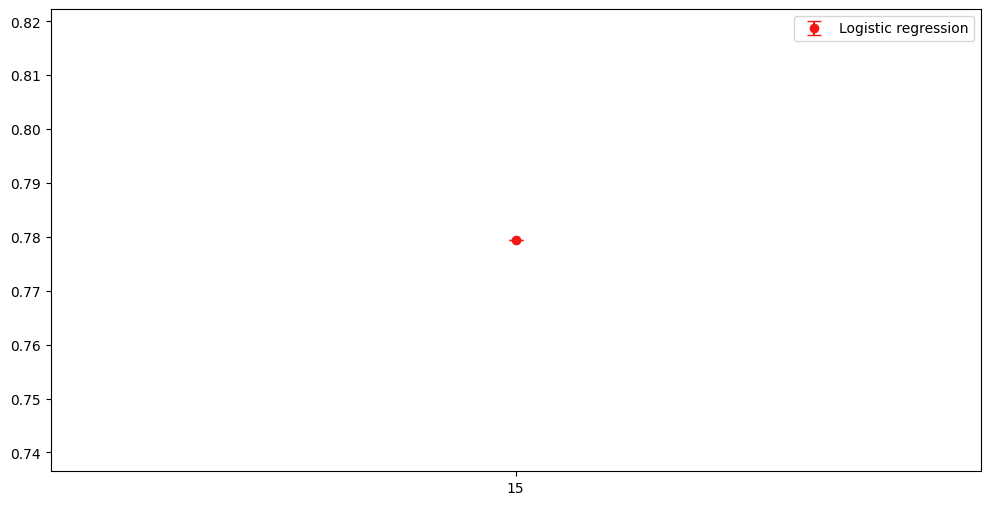

In [27]:
import random

all_feats_sup_trans = all_feats_sup - all_feats_sup.mean(dim=0)
all_feats_sup_trans /= all_feats_sup_trans.std(dim=0)

n_dims = all_feats_sup_trans.shape[1]
models = {
  "Logistic regression": MLP([n_dims,2]),  
#   "1 hidden layer (64)": MLP([n_dims,64,2]),
#   "1 hidden layer (64) + dropout(0.2)": MLP([n_dims,64,2],dropout=0.2)
} 


ks = [1,2,3,4,5,10,15,20]
ks = [15]
num_attempts = 1
fig,ax = plt.subplots(1,1,figsize=(12,6))
for mi, (model_name, model) in enumerate(models.items()):
    all_accs = []
    for attempt_i in range(num_attempts):
        accs = []
        for k in ks:
            

            mask_fg = torch.tensor([v.item() for v in random.choices(torch.nonzero(sup_labels==0),k=k)])
            mask_bg = torch.tensor([v.item() for v in random.choices(torch.nonzero(sup_labels==1),k=k)])

            mask_train = torch.zeros(sup_labels.shape[0],dtype=torch.int64).bool()
            mask_train[mask_fg] = True
            mask_train[mask_bg] = True



            train_feats = all_feats_sup_trans[mask_train]
            train_y = sup_labels[mask_train]

            model.fit(train_feats, train_y,epochs=1000)

            pred = model.predict(all_feats_sup_trans.to(device='cuda')).detach().cpu().numpy()
            pred = np.argmax(pred, axis=1)
            acc = (sup_labels == pred).sum() / pred.shape[0]
            accs.append(acc)
        all_accs.append(accs)
    all_accs = np.array(all_accs)
    accs = np.mean(all_accs, axis=0)
    accs_std = np.std(all_accs,axis=0)
    color=index_to_color(mi)
    ks_s = np.array(ks)
    ax.errorbar(ks_s,accs,yerr= accs_std,fmt='o', capsize=5, label=model_name, color = color,linestyle='none')
    ax.plot(ks_s,accs,color=color)
    ax.fill_between(ks_s,accs-accs_std,accs+accs_std, color=color, alpha=0.2,)

ax.set_xticks(ks)
ax.legend()
plt.show()











In [207]:
accs

array([0.6880857], dtype=float32)

In [28]:
y = torch.zeros(sup_f.shape[0], dtype = torch.int64)
y[mask_fg]=1


pred_viz = model.predict(all_feats_sup_trans.to(device='cuda')).detach().cpu().numpy()[:,1]
pred_viz -= pred.min()
pred_viz /= pred.max()
plotter6 = pv.Plotter(notebook=True)
pcd_poly_scores = pv.PolyData(pos)

pcd_poly_scores['s'] = pred_viz[sup_f]

# pcd_poly_scores['s'][torch.isin(torch.as_tensor(sup_f).long(),mask_0)] = [0,0,1]
# pcd_poly_scores['s'][torch.isin(torch.as_tensor(sup_f).long(),mask_1)] = [0,1,0]

plotter6.add_mesh(pcd_poly_scores,scalars='s',rgb=False)
plotter6.show()

Widget(value='<iframe src="http://localhost:33103/index.html?ui=P_0x7be3bc197f80_6&reconnect=auto" class="pyvi…

In [29]:
def calibrate_mrf(node_feats, cost_source, cost_sink, first_edg, adj_verts):
    d2 = []
    for u in range(V):
        for k in range(first_edg[u], first_edg[u+1]):
            v = adj_verts[k]
            d2.append(np.sum((node_feats[u] - node_feats[v])**2))
    d2 = np.array(d2)
    m = np.median(d2)

    beta = np.log(2)/m
    delta = np.abs(cost_source - cost_sink)
    lmbda = np.median(delta)

    return beta, lmbda

In [30]:
import maxflow
def solve_mincut(node_feats, cost_source, cost_sink, first_edg, adj_verts, lmbda, beta):
    
    V,F = node_feats.shape
    g = maxflow.Graph[float](V, adj_verts.size)
    g.add_nodes(V)
    # t-links
    for u in range(V):
        g.add_tedge(u, cost_source[u], cost_sink[u])

    # pairwise links
    for u in range(V):
        start, end = first_edg[u], first_edg[u+1]
        u_feat = node_feats[u]
        for idx in range(start,end):
            v = adj_verts[idx]
            v_feat = node_feats[v]
            diff = u_feat - v_feat
            w = lmbda * np.exp(-beta * (diff@diff))
            g.add_edge(u,v,w,w)
    # solve
    flow = g.maxflow()
    print(f"DEBUG solved mincut with {flow=}")


    # y = torch.zeros(sup_f.shape[0], dtype = torch.int64)
    # y[mask_fg]=1

    labels = np.array([g.get_segment(u) for u in range(V)])
    return labels


In [34]:
### CONFIG
config_k = 10 # picks per class

# initial mask (simulated picks)
mask_fg = torch.tensor([v.item() for v in random.choices(torch.nonzero(sup_labels==0),k=config_k)])
mask_bg = torch.tensor([v.item() for v in random.choices(torch.nonzero(sup_labels==1),k=config_k)])

mask_train = torch.zeros(sup_labels.shape[0],dtype=torch.int64).bool()
mask_train[mask_fg] = True
mask_train[mask_bg] = True


In [35]:
sup_centroids = scatter_mean(torch.as_tensor(pos), torch.as_tensor(sup_f,dtype=torch.int64),dim=0)
sup_centroids_fg = sup_centroids[mask_fg]
sup_centroids_bg = sup_centroids[mask_bg]




In [ ]:
# min-cut solution
import maxflow
import numpy as np

### CONFIG
config_epochs = 1000



# inputs
V,F = all_feats_sup_trans.shape
node_feats = all_feats_sup_trans.numpy()
node_feats_t = torch.as_tensor(node_feats)
model = MLP([node_feats.shape[1],64,2],dropout=0.2)





train_feats = all_feats_sup_trans[mask_train]
train_y = sup_labels[mask_train]

# grab graph info
first_edg = graph_f[0] # [V]
adj_verts = graph_f[1] # [E]

# solve
# iteration 0
model.fit(train_feats, train_y,epochs=config_epochs)
preds = model(node_feats_t.to(device='cuda')).detach().cpu().numpy()
print(f"Unary Accuracy: {((sup_labels.numpy() == np.argmax(preds, axis=1)).sum()/preds.shape[0]).item()*100:.3f}%")
cost_source     = - preds[:,1]
cost_sink       = - preds[:,0]


beta,lmbda = calibrate_mrf(node_feats, cost_source, cost_sink, first_edg, adj_verts)
labels = solve_mincut(node_feats, cost_source, cost_sink, first_edg, adj_verts, lmbda, beta)
print(f"Accuracy: {((sup_labels.numpy() == labels.astype(bool)).sum()/labels.shape[0]).item()*100:.3f}%")

# iteration 1
labels = torch.as_tensor(labels,dtype=torch.int64)
node_feats_t = all_feats_sup_trans
model.fit(node_feats_t, labels, epochs=config_epochs)
preds = model(node_feats_t.to(device='cuda')).detach().cpu().numpy()
cost_source     = - preds[:,1]
cost_sink       = - preds[:,0]
labels = solve_mincut(node_feats, cost_source, cost_sink, first_edg, adj_verts, lmbda, beta)
print(f"Accuracy: {((sup_labels.numpy() == labels.astype(bool)).sum()/labels.shape[0]).item()*100:.3f}%")

# iteration 2
labels = torch.as_tensor(labels,dtype=torch.int64)
node_feats_t = all_feats_sup_trans
model.fit(node_feats_t, labels, epochs=config_epochs)
preds = model(node_feats_t.to(device='cuda')).detach().cpu().numpy()
cost_source     = - preds[:,1]
cost_sink       = - preds[:,0]
labels = solve_mincut(node_feats, cost_source, cost_sink, first_edg, adj_verts, lmbda, beta)
print(f"Accuracy: {((sup_labels.numpy() == labels.astype(bool)).sum()/labels.shape[0]).item()*100:.3f}%")


# iteration 3
labels = torch.as_tensor(labels,dtype=torch.int64)
node_feats_t = all_feats_sup_trans
model.fit(node_feats_t, labels, epochs=config_epochs)
preds = model(node_feats_t.to(device='cuda')).detach().cpu().numpy()
cost_source     = - preds[:,1]
cost_sink       = - preds[:,0]
labels = solve_mincut(node_feats, cost_source, cost_sink, first_edg, adj_verts, lmbda, beta)
print(f"Accuracy: {((sup_labels.numpy() == labels.astype(bool)).sum()/labels.shape[0]).item()*100:.3f}%")


# iteration 4
labels = torch.as_tensor(labels,dtype=torch.int64)
node_feats_t = all_feats_sup_trans
model.fit(node_feats_t, labels, epochs=config_epochs)
preds = model(node_feats_t.to(device='cuda')).detach().cpu().numpy()
cost_source     = - preds[:,1]
cost_sink       = - preds[:,0]
labels = solve_mincut(node_feats, cost_source, cost_sink, first_edg, adj_verts, lmbda, beta)
print(f"Accuracy: {((sup_labels.numpy() == labels.astype(bool)).sum()/labels.shape[0]).item()*100:.3f}%")

# iteration 4
labels = torch.as_tensor(labels,dtype=torch.int64)
node_feats_t = all_feats_sup_trans
model.fit(node_feats_t, labels, epochs=config_epochs)
preds = model(node_feats_t.to(device='cuda')).detach().cpu().numpy()
cost_source     = - preds[:,1]
cost_sink       = - preds[:,0]
labels = solve_mincut(node_feats, cost_source, cost_sink, first_edg, adj_verts, lmbda, beta)
print(f"Accuracy: {((sup_labels.numpy() == labels.astype(bool)).sum()/labels.shape[0]).item()*100:.3f}%")

# # iteration 4
# labels = torch.as_tensor(labels,dtype=torch.int64)
# node_feats_t = all_feats_sup_trans
# model.fit(node_feats_t, labels, epochs=config_epochs)
# preds = model(node_feats_t.to(device='cuda')).detach().cpu().numpy()
# cost_source     = - preds[:,1]
# cost_sink       = - preds[:,0]
# labels = solve_mincut(node_feats, cost_source, cost_sink, first_edg, adj_verts, lmbda, beta)
# print(f"Accuracy: {((sup_labels.numpy() == labels.astype(bool)).sum()/labels.shape[0]).item()*100:.3f}%")

# # iteration 4
# labels = torch.as_tensor(labels,dtype=torch.int64)
# node_feats_t = all_feats_sup_trans
# model.fit(node_feats_t, labels, epochs=config_epochs)
# preds = model(node_feats_t.to(device='cuda')).detach().cpu().numpy()
# cost_source     = - preds[:,1]
# cost_sink       = - preds[:,0]
# labels = solve_mincut(node_feats, cost_source, cost_sink, first_edg, adj_verts, lmbda, beta)
# print(f"Accuracy: {((sup_labels.numpy() == labels.astype(bool)).sum()/labels.shape[0]).item()*100:.3f}%")

# # iteration 4
# labels = torch.as_tensor(labels,dtype=torch.int64)
# node_feats_t = all_feats_sup_trans
# model.fit(node_feats_t, labels, epochs=config_epochs)
# preds = model(node_feats_t.to(device='cuda')).detach().cpu().numpy()
# cost_source     = - preds[:,1]
# cost_sink       = - preds[:,0]
# labels = solve_mincut(node_feats, cost_source, cost_sink, first_edg, adj_verts, lmbda, beta)
# print(f"Accuracy: {((sup_labels.numpy() == labels.astype(bool)).sum()/labels.shape[0]).item()*100:.3f}%")

# # iteration 4
# labels = torch.as_tensor(labels,dtype=torch.int64)
# node_feats_t = all_feats_sup_trans
# model.fit(node_feats_t, labels, epochs=config_epochs)
# preds = model(node_feats_t.to(device='cuda')).detach().cpu().numpy()
# cost_source     = - preds[:,1]
# cost_sink       = - preds[:,0]
# labels = solve_mincut(node_feats, cost_source, cost_sink, first_edg, adj_verts, lmbda, beta)
# print(f"Accuracy: {((sup_labels.numpy() == labels.astype(bool)).sum()/labels.shape[0]).item()*100:.3f}%")



plotter7 = pv.Plotter(notebook=True)
pcd_poly_mincut = pv.PolyData(pos)

pcd_poly_mincut['s'] = labels[sup_f]


# pcd_poly_scores['s'][torch.isin(torch.as_tensor(sup_f).long(),mask_0)] = [0,0,1]
# pcd_poly_scores['s'][torch.isin(torch.as_tensor(sup_f).long(),mask_1)] = [0,1,0]

plotter7.add_mesh(pcd_poly_mincut,scalars='s',rgb=False,cmap=['#ae8484','#c7e881'],categories=True)

for centroid in sup_centroids_fg:
    sp = pv.Sphere(0.2,centroid.numpy())
    plotter7.add_mesh(sp, color='f01c1c')

for centroid in sup_centroids_bg:
    sp = pv.Sphere(0.2,centroid.numpy())
    plotter7.add_mesh(sp, color='#a8f209')

plotter7.show()
reset_camera_standard(plotter7)

DEBUG fit MLP with loss=0.069
Unary Accuracy: 76.667%
DEBUG solved mincut with flow=411.97863396920377
Accuracy: 79.206%
DEBUG fit MLP with loss=0.036
DEBUG solved mincut with flow=319.25224340895915
Accuracy: 79.206%
DEBUG fit MLP with loss=0.037
DEBUG solved mincut with flow=315.7872796951855
Accuracy: 79.048%
DEBUG fit MLP with loss=0.031
DEBUG solved mincut with flow=308.105334391302
Accuracy: 79.206%
DEBUG fit MLP with loss=0.039
DEBUG solved mincut with flow=301.28408383794215
Accuracy: 79.365%
DEBUG fit MLP with loss=0.033
DEBUG solved mincut with flow=299.2979234488266
Accuracy: 79.365%
DEBUG fit MLP with loss=0.044
DEBUG solved mincut with flow=307.0210024561019
Accuracy: 79.365%
DEBUG fit MLP with loss=0.042
DEBUG solved mincut with flow=302.99421392162725
Accuracy: 79.365%
DEBUG fit MLP with loss=0.034
DEBUG solved mincut with flow=307.3539766951646
Accuracy: 79.206%
DEBUG fit MLP with loss=0.031
DEBUG solved mincut with flow=305.54483064035014
Accuracy: 78.889%


Widget(value='<iframe src="http://localhost:33103/index.html?ui=P_0x7be3dd575c70_8&reconnect=auto" class="pyvi…